<center>
  <h1>
    EA3. PROYECTO INTEGRADOR
  </h1>
</center>

<h1>
  Autor: Felipe Fernández Rodriguez
</h1>

## 📹 Video Explicativo
Aquí presento la explicación detallada de la transformación y los hallazgos:

<a href="https://drive.google.com/file/d/1CrFP7ArQkXYPuuAa3nQpu3fqb4PfsFYU/view?usp=sharing" target="_blank">Haga clic aquí para ver el video</a>

In [0]:
name_catalog = 'hospital_san_juan_de_dios'
name_schema = 'hospital_beds_db'
volume_name = 'raw_data'
table_name = ['tbl_patients', 'tbl_services', 'tbl_staff', 'tbl_schedule']
csv_name = ['patients.csv', 'services_weekly.csv', 'staff.csv', 'staff_schedule.csv']

# Creación del catalogo
spark.sql("""
        CREATE CATALOG IF NOT EXISTS {}
        COMMENT 'Catálogo del Hospital San Juan de Dios - Proyecto Big Data'
    """.format(name_catalog))

spark.sql("""
       USE CATALOG {}   
    """.format(name_catalog))

# Creación del schema
spark.sql("""
    CREATE SCHEMA IF NOT EXISTS {}
    COMMENT 'Esquema principal del proyecto Hospital Beds Management'
    """.format(name_schema))

spark.sql("""
    USE SCHEMA {}
    """.format(name_schema))

# Creación del volumen para el almacenamiento de los archivos CSV
spark.sql("""
    CREATE VOLUME IF NOT EXISTS {}
    COMMENT 'Volumen que almacena los archivos CSV del proyecto'
    """.format(volume_name))

# Obtener la ruta del volumen
volume_path = '/Volumes/hospital_san_juan_de_dios/hospital_beds_db/raw_data/'

# Lectura de los archivos CSV y carga de los DataFrames en el esquema 'hospital_beds_db'
for i in range(4):
    # Lee el archivo CSV y lo carga en un DataFrame de Spark
    df = spark.read\
        .option('header', True)\
        .option('delimiter', ',')\
        .option('inferSchema', True)\
        .csv('{}{}'.format(volume_path, csv_name[i]))
        
    # Guarda el DataFrame como una tabla permanente en el esquema 'hospital_beds_db'
    df.write.mode('overwrite').saveAsTable("{}.{}.{}".format(name_catalog, name_schema, table_name[i]))

<h3>
  Transformaciones: columnas de fecha
</h3>

In [0]:
from pyspark.sql import functions as F

# Configuración para permitir patrones de fecha antiguos (Spark 2.x)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Referencia a la tabla cargada previamente
full_table_name = f"{name_catalog}.{name_schema}.tbl_patients"
df_patients = spark.table(full_table_name)

# Aplicamos las transformaciones
df_patients_transformed = (df_patients
  # 1. Asegurar formato fecha (Casting explícito si fuera necesario)
  .withColumn("fecha_ingreso", F.to_date("arrival_date"))
  
  # 2. Derivar columnas de tiempo
  .withColumn("anio", F.year("fecha_ingreso"))
  .withColumn("mes", F.month("fecha_ingreso"))
  .withColumn("dia", F.dayofmonth("fecha_ingreso"))
  # 'u' en date_format devuelve el día de la semana estandar ISO (1=Lunes... 7=Domingo)
  .withColumn("dia_semana", F.date_format("fecha_ingreso", "u").cast("int"))
  # 'EEEE' devuelve el nombre completo del día (Monday, Tuesday...)
  # Nota: El idioma dependerá de la configuración regional del clúster (generalmente inglés)
  .withColumn("nombre_dia", F.date_format("fecha_ingreso", "EEEE")) 
)

# Visualizamos el resultado
print("Transformaciones de Fecha en tbl_patients:")
display(df_patients_transformed.select("patient_id", "arrival_date", "fecha_ingreso", "anio", "mes", "dia_semana", "nombre_dia").limit(5))

# Guardar esta vista enriquecida para siguientes pasos
df_patients_transformed.write.mode("overwrite").saveAsTable(f"{name_catalog}.{name_schema}.tbl_patients_enriched")

Transformaciones de Fecha en tbl_patients:


patient_id,arrival_date,fecha_ingreso,anio,mes,dia_semana,nombre_dia
PAT-09484753,2025-03-16,2025-03-16,2025,3,7,Sunday
PAT-f0644084,2025-12-13,2025-12-13,2025,12,6,Saturday
PAT-ac6162e4,2025-06-29,2025-06-29,2025,6,7,Sunday
PAT-3dda2bb5,2025-10-12,2025-10-12,2025,10,7,Sunday
PAT-08591375,2025-02-18,2025-02-18,2025,2,2,Tuesday


In [0]:
%sql
-- Equivalente en SQL para validar transformaciones
SELECT 
    patient_id,
    to_date(arrival_date) AS fecha_ingreso,
    year(arrival_date) AS anio,
    month(arrival_date) AS mes,
    day(arrival_date) AS dia,
    date_format(arrival_date, 'u') AS dia_semana,
    date_format(arrival_date, 'EEEE') AS nombre_dia
FROM hospital_san_juan_de_dios.hospital_beds_db.tbl_patients
LIMIT 10;

patient_id,fecha_ingreso,anio,mes,dia,dia_semana,nombre_dia
PAT-09484753,2025-03-16,2025,3,16,7,Sunday
PAT-f0644084,2025-12-13,2025,12,13,6,Saturday
PAT-ac6162e4,2025-06-29,2025,6,29,7,Sunday
PAT-3dda2bb5,2025-10-12,2025,10,12,7,Sunday
PAT-08591375,2025-02-18,2025,2,18,2,Tuesday
PAT-f4b29bae,2025-06-26,2025,6,26,4,Thursday
PAT-283cda07,2025-12-26,2025,12,26,5,Friday
PAT-5b61868c,2025-05-21,2025,5,21,3,Wednesday
PAT-f9c8afa6,2025-07-30,2025,7,30,3,Wednesday
PAT-5290be70,2025-11-01,2025,11,1,6,Saturday


<h3>
  Nueva tabla: resumen por mes
</h3>

In [0]:
resumen_mensual = (df_patients_transformed.groupBy("anio", "mes")
  .agg(
    F.count("*").alias("total_ingresos"),               # Total de registros/ingresos
    F.countDistinct("patient_id").alias("pacientes_unicos"), # Pacientes únicos (útil si hay reingresos)
    F.round(F.avg("satisfaction"), 2).alias("satisfaccion_promedio"), # Promedio de satisfacción
    F.round(F.avg("age"), 1).alias("edad_promedio")     # Promedio de edad
  )
  .orderBy("anio", "mes") # Ordenamos cronológicamente
)

# Vista previa en el notebook
print("Vista previa del resumen mensual:")
resumen_mensual.show(5)

# Guardamos la tabla en el catálogo
table_save_name = f"{name_catalog}.{name_schema}.resumen_mensual"
resumen_mensual.write.mode("overwrite").saveAsTable(table_save_name)

print(f"Tabla guardada exitosamente en: {table_save_name}")

Vista previa del resumen mensual:
+----+---+--------------+----------------+---------------------+-------------+
|anio|mes|total_ingresos|pacientes_unicos|satisfaccion_promedio|edad_promedio|
+----+---+--------------+----------------+---------------------+-------------+
|2025|  1|            85|              85|                80.22|         44.6|
|2025|  2|            80|              80|                79.28|         42.0|
|2025|  3|            75|              75|                76.75|         44.8|
|2025|  4|            81|              81|                81.49|         42.6|
|2025|  5|            85|              85|                80.81|         48.6|
+----+---+--------------+----------------+---------------------+-------------+
only showing top 5 rows
Tabla guardada exitosamente en: hospital_san_juan_de_dios.hospital_beds_db.resumen_mensual


In [0]:
%sql
-- Equivalente en SQL resumen mensual
CREATE OR REPLACE TABLE hospital_san_juan_de_dios.hospital_beds_db.resumen_mensual AS
SELECT
  year(arrival_date) AS anio,
  month(arrival_date) AS mes,
  COUNT(*) AS total_ingresos,
  COUNT(DISTINCT patient_id) AS pacientes_unicos,
  ROUND(AVG(satisfaction), 2) AS satisfaccion_promedio,
  ROUND(AVG(age), 1) AS edad_promedio
FROM hospital_san_juan_de_dios.hospital_beds_db.tbl_patients
GROUP BY year(arrival_date), month(arrival_date)
ORDER BY anio, mes;

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM hospital_san_juan_de_dios.hospital_beds_db.resumen_mensual LIMIT 10;

anio,mes,total_ingresos,pacientes_unicos,satisfaccion_promedio,edad_promedio
2025,1,85,85,80.22,44.6
2025,2,80,80,79.28,42.0
2025,3,75,75,76.75,44.8
2025,4,81,81,81.49,42.6
2025,5,85,85,80.81,48.6
2025,6,81,81,79.02,43.8
2025,7,82,82,78.84,45.2
2025,8,88,88,78.41,44.8
2025,9,94,94,79.22,48.5
2025,10,92,92,79.84,47.2


<h3>
  Limpieza: evidencia antes/después
</h3>

In [0]:
from pyspark.sql import types as T

# 1. Cargar datos desde la tabla ENRIQUECIDA (la que ya tiene fechas)
# Asegúrate de que esta tabla exista en tu catálogo
df_original = spark.table(f"{name_catalog}.{name_schema}.tbl_patients_enriched")
df_before = df_original 

# --- INICIO PROCESO DE LIMPIEZA ---

# A) Trim y Normalización de Texto (Columna: service)
df_step1 = df_original.withColumn("service_clean", F.lower(F.trim(F.col("service"))))

# B) Casteo de Tipos y Manejo de Valores Inválidos (Columnas: satisfaction, age)
df_step2 = df_step1.withColumn("satisfaction", F.col("satisfaction").cast(T.DoubleType()))

# Validación de edad negativa
df_step2 = df_step2.withColumn("age", 
                               F.when(F.col("age") < 0, None)
                               .otherwise(F.col("age")))

# C) Imputación de Nulos (Columna: age)
media_edad = df_step2.select(F.mean("age")).first()[0]
df_step3 = df_step2.na.fill({"age": media_edad})

# D) Remoción de Outliers usando IQR (Columna: age)
q25, q75 = df_step3.approxQuantile("age", [0.25, 0.75], 0.01)
iqr = q75 - q25
limite_inferior = q25 - 1.5 * iqr
limite_superior = q75 + 1.5 * iqr

df_limpio = df_step3.filter((F.col("age") >= limite_inferior) & (F.col("age") <= limite_superior))

# --- EVIDENCIAS ---
print("---------------------------------------------------------")
print(f"Registros antes: {df_before.count()} | Registros después (sin outliers): {df_limpio.count()}")
print("---------------------------------------------------------")

print("EVIDENCIA 1: Normalización (service vs service_clean)")
display(df_limpio.select("service", "service_clean").distinct().limit(5))

print("EVIDENCIA 2: Verificación de columnas (Debe incluir fechas y datos limpios)")
# Ahora veremos patient_id, service_clean, age, satisfaction Y TAMBIÉN nombre_dia, mes, etc.
display(df_limpio.limit(5))

# Guardar tabla limpia final
df_limpio.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable(f"{name_catalog}.{name_schema}.tbl_patients_cleaned")
print(f"Tabla guardada: {name_catalog}.{name_schema}.tbl_patients_cleaned")

---------------------------------------------------------
Registros antes: 1000 | Registros después (sin outliers): 1000
---------------------------------------------------------
EVIDENCIA 1: Normalización (service vs service_clean)


service,service_clean
surgery,surgery
general_medicine,general_medicine
emergency,emergency
ICU,icu


EVIDENCIA 2: Verificación de columnas (Debe incluir fechas y datos limpios)


patient_id,name,age,arrival_date,departure_date,service,satisfaction,fecha_ingreso,anio,mes,dia,dia_semana,nombre_dia,service_clean
PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61.0,2025-03-16,2025,3,16,7,Sunday,surgery
PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83.0,2025-12-13,2025,12,13,6,Saturday,surgery
PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83.0,2025-06-29,2025,6,29,7,Sunday,general_medicine
PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81.0,2025-10-12,2025,10,12,7,Sunday,emergency
PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76.0,2025-02-18,2025,2,18,2,Tuesday,icu


Tabla guardada: hospital_san_juan_de_dios.hospital_beds_db.tbl_patients_cleaned


<h3>
  Justificación de la limpieza
</h3>

<ol>
  <li>
    Normalización (service): Es vital para las agregaciones. Si tenemos "Surgery" y "surgery ", el sistema los contaría como dos categorías diferentes, falseando las estadísticas de ocupación por servicio.
  </li>
  <li>
    Casteo e Imputación (age, satisfaction): Convertir a numérico permite realizar cálculos matemáticos (media, desviación). La imputación por media preserva el tamaño de la muestra sin sesgar significativamente la tendencia central, permitiendo análisis demográficos completos sin perder filas por errores de digitación.
  </li>
  <li>
    Manejo de Outliers (IQR): Eliminar valores extremos (ej. una edad de 150 años por error de dedo) evita que el promedio de edad se dispare artificialmente, asegurando que el perfil del paciente represente a la población real del hospital.
  </li>
</ol>

<h3>
  Visualizaciones por agrupaciones categóricas
</h3>

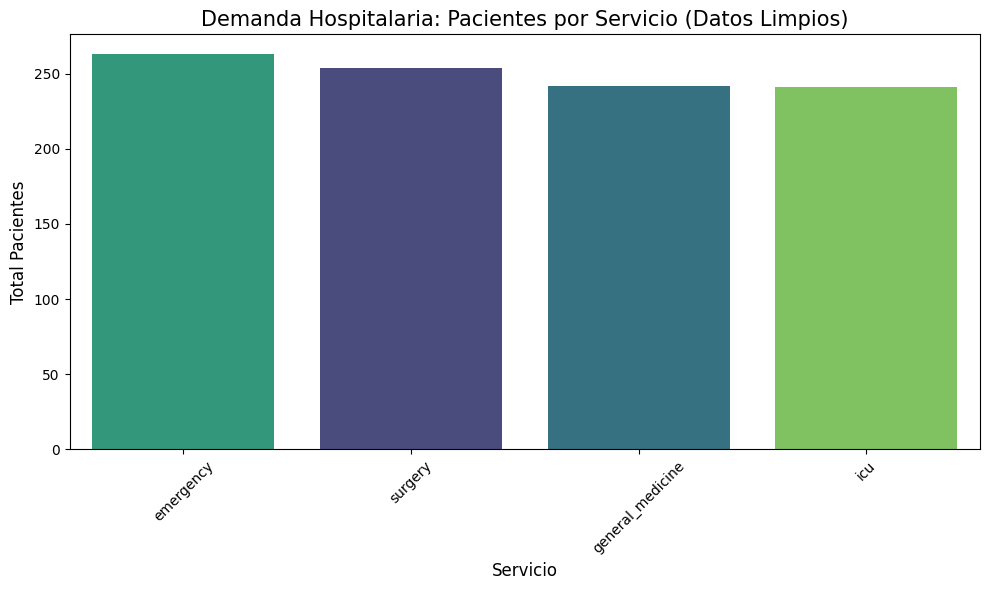

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

# 1. Convertimos el DataFrame limpio final a Pandas
pdf = df_limpio.toPandas()

# 2. Ordenamos por día de la semana
try:
    pdf = pdf.sort_values('dia_semana')
except KeyError:
    print("Advertencia: No se encontró columna 'dia_semana' para ordenar, se usará el orden por defecto.")

# --- VISUALIZACIÓN A: Demanda por Servicio (Seaborn) ---
plt.figure(figsize=(10, 6))
sns.countplot(
    data=pdf, 
    x="service_clean", 
    hue="service_clean",
    legend=False,
    palette="viridis",
    order=pdf['service_clean'].value_counts().index
)
plt.title("Demanda Hospitalaria: Pacientes por Servicio (Datos Limpios)", fontsize=15)
plt.xlabel("Servicio", fontsize=12)
plt.ylabel("Total Pacientes", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<h3>
  Interpretación: Demanda Hospitalaria por Servicio
</h3>
<p>
  La visualización revela una distribución de carga de trabajo sorprendentemente equilibrada entre las cuatro áreas principales. Aunque 'Emergency' (Urgencias) presenta la mayor afluencia con un ligero margen superior a los 260 pacientes, la diferencia con áreas como 'ICU' (Cuidados Intensivos) o 'General Medicine' es mínima. Esto sugiere que el hospital opera con capacidades asignadas o cuotas muy similares para cada departamento, sin que exista un solo servicio que monopolice drásticamente los recursos.
</p>

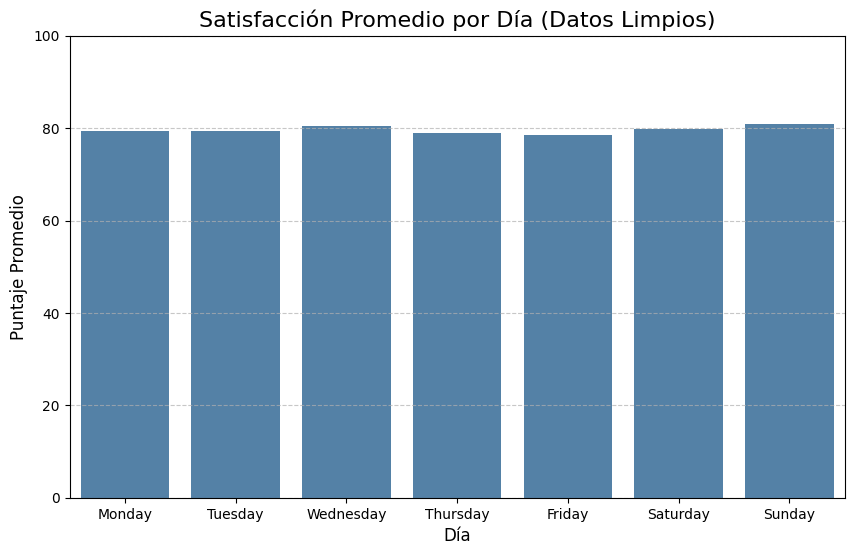

In [0]:
# --- VISUALIZACIÓN B: Satisfacción por Día ---
# Agrupamos por nombre del día
df_agrupado = pdf.groupby(['nombre_dia'])['satisfaction'].mean().reset_index()

# Definir orden lógico de días
orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 6)) # Tamaño de la imagen

# Usamos Seaborn para dibujar las barras
sns.barplot(
    data=df_agrupado, 
    x="nombre_dia", 
    y="satisfaction", 
    order=orden_dias, # Esto fuerza el orden cronológico
    color="steelblue" # Un solo color sólido se ve mejor para comparar alturas
)

# Personalización
plt.title("Satisfacción Promedio por Día (Datos Limpios)", fontsize=16)
plt.xlabel("Día", fontsize=12)
plt.ylabel("Puntaje Promedio", fontsize=12)
plt.ylim(0, 100) # Equivalente a range_y=[0, 100]
plt.grid(axis='y', linestyle='--', alpha=0.7) # Agrega líneas de guía horizontales

plt.show()

<h3>
  Interpretación: Satisfacción Promedio por Día
</h3>
<p>
  El gráfico de barras muestra una estabilidad notable en la calidad del servicio percibida, con un puntaje de satisfacción que se mantiene constante alrededor de 80/100 independientemente del día de la semana. La ausencia de caídas significativas durante los fines de semana (sábado/domingo) indica una gestión de personal eficiente que logra mantener los estándares de atención incluso fuera de los días hábiles típicos.
</p>